まずはライブラリをインポートする

In [8]:
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
%matplotlib inline

次にデータを生成し，適当に欠損させる．説明変数は`x1`と`x2`であり，目的変数は`y`とする．それぞれは
$$
x_1 \sim \mathcal{N}(2.0, 0.4) \\
x_2 \mid x_1 \sim \mathcal{N}(-2.0 x_1 + 0.5, 0.8) \\
y \mid x_1,x_2 \sim \mathcal{N}(3.0 x_1 + 1.5x_2, 0.8)
$$
という関係にあるものとする．

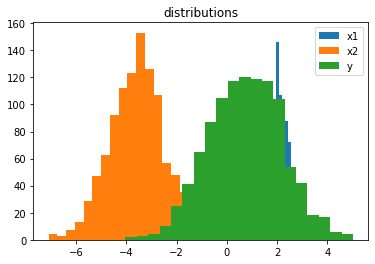

In [21]:
N_train, N_test = 60, 1000
X = np.zeros((N_train + N_test, 2))
y = np.zeros(N_train + N_test)
X[:,0] = np.random.normal(2.0, 0.4, size = N_train + N_test)
X[:,1] = np.random.normal(-2.0*X[:,0] + 0.5, 0.8, size = N_train + N_test)
y = np.random.normal(3.0*X[:,0] + 1.5*X[:,1], 0.8, size = N_train + N_test)
X_train_complete = X[:N_train]
y_train = y[:N_train]
X_test = X[N_train:]
y_test = y[N_train:]

plt.hist(X[:,0], bins = 20, label = "x1")
plt.hist(X[:,1], bins = 20, label = "x2")
plt.hist(y, bins = 20, label = "y")
plt.title("distributions")
plt.legend()

$p = 0.3$の確率で説明変数を欠損させる．欠損した位置や値は`table_missing`で保存する．

In [22]:
p = 0.3
X_train = X_train_complete.copy()
is_nan_X_train = np.zeros(X_train.shape, dtype = "int")
for idx in range(len(X_train)):
    if np.random.rand() < p:
        is_nan_X_train[idx, 0] = 1
        X_train[idx, 0] = np.nan
    
    if np.random.rand() < p:
        is_nan_X_train[idx, 1] = 1
        X_train[idx, 1] = np.nan
print(X_train[0:10])

[[ 1.58535427         nan]
 [ 2.10601671 -4.55318535]
 [ 1.80926526 -3.5396434 ]
 [ 2.38851039 -4.33333887]
 [ 1.42494009         nan]
 [ 1.4851974  -2.11832497]
 [ 2.36502598 -3.75242383]
 [        nan -2.56203429]
 [ 1.40867681 -2.91245052]
 [ 2.34858366         nan]]


In [23]:
print("=====最尤推定(complete data)=====")
w_ML = np.linalg.inv(X_train_complete.T.dot(X_train_complete)).dot(X_train_complete.T).dot(y_train)
y_pred = X_test.dot(w_ML)
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))

print("=====最尤推定(dropped)=====")
X_train_dropped = X_train[is_nan_X_train.sum(1) == 0]
y_train_dropped = y_train[is_nan_X_train.sum(1) == 0]
w_ML = np.linalg.inv(X_train_dropped.T.dot(X_train_dropped)).dot(X_train_dropped.T).dot(y_train_dropped)
y_pred = X_test.dot(w_ML)
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))

print("=====最尤推定(interpolated)=====")
X_train_interpolated = X_train.copy()
X_train_interpolated[np.isnan(X_train)] = np.tile(np.nanmean(X_train, axis = 0), reps = (len(X_train,),1))[np.isnan(X_train)]
w_ML = np.linalg.inv(X_train_interpolated.T.dot(X_train_interpolated)).dot(X_train_interpolated.T).dot(y_train)
y_pred = X_test.dot(w_ML)
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))

=====最尤推定(complete data)=====
y_error = 0.6841894767175021
=====最尤推定(dropped)=====
y_error = 0.7259293059445424
=====最尤推定(interpolated)=====
y_error = 0.9199739418129449


説明変数の補間が可能な，ベイズ線形回帰のクラスを構成する．

In [24]:
class Bayesian_LR_with_interpolation: # 説明変数の補間が可能な，ベイズ線形回帰
    def __init__(self, alpha = 1.0, beta = 1.0):
        self.alpha = alpha # alphaはパラメータwの事前分布のパラメータで，alphaが大きいほどwの分布は狭くなる．
        self.beta = beta # betaは誤差のオーダーの逆数
    
    def fit(self, X_train_original, y_train_original, num_sample = 1000, fit_hyper_parameters = True, num_iteration = 100, eta = 0.1):
        dalpha = 0.01
        dbeta = 0.01
        self.hyper_param_record = np.zeros((num_iteration, 2)) # ハイパーパラメータの軌跡を保存
        self.normalize_train(X_train_original, y_train_original) # 標準化されたself.X_train, self.y_trainが生成される
        if len(self.nan_list) == 0:
            print("Note: There are no missing values in the explanatory variables.")
        
        w_sample_mean = np.zeros(len(self.X_train[0])) # サンプリングから計算したwの期待値を格納
        w_sample_std = np.zeros(len(self.X_train[0])) # サンプリングから計算したwの標準偏差を格納
        X_sample_mean = self.X_train.copy() # サンプリングから計算したXの期待値を格納，欠損値だけ更新
        X_sample_std = np.zeros(self.X_train.shape) # サンプリングから計算したXの標準偏差を格納，欠損値だけ更新
        X_sample = self.X_train.copy() # 現時点でのサンプルの値，欠損値だけ更新する
        self.w_samples = np.zeros((num_sample, len(self.X_train[0]))) # wに関するサンプリング結果をすべて集める，予測の際に必要
        
        # ハイパーパラメータを調整，勾配法により尤度を上げるようなハイパーパラメータを探す
        if fit_hyper_parameters: # ハイパーパラメータを調整する場合
            likelihood = self.likelihood(num_sample) # 初期化
            for idx_iteration in range(num_iteration):
                self.hyper_param_record[idx_iteration] = np.array([self.alpha, self.beta])
                self.alpha = self.alpha + dalpha
                likelihood_new = self.likelihood(num_sample)
                self.alpha = self.alpha - dalpha + eta*(likelihood_new - likelihood) / dalpha
                likelihood = likelihood_new
                self.beta = self.beta + dbeta
                likelihood_new = self.likelihood(num_sample) # 新しい尤度を計算
                self.beta = self.beta - dbeta + eta*(likelihood_new - likelihood) / dbeta
                likelihood = likelihood_new
                print("iteraton = {0:} / {1:}: alpha = {2:.6f}, beta = {3:.6f}, L = {4:.6f}".format(idx_iteration, num_iteration, self.alpha, self.beta, likelihood), end = "\r")
        
        # サンプリングによりwとXの統計量を計算
        for t in range(num_sample):
            # wのサンプリング
            w_sample = self.sample_w(X_sample)
            self.w_samples[t] = w_sample # predictionで使うため
            w_sample_mean = self.update_mean(w_sample_mean, w_sample, t)
            w_sample_std = self.update_std(w_sample_std, w_sample, t)
            
            # Xのサンプリング(欠損している箇所のみ)
            for idx, (n, m) in enumerate(self.nan_list):
                X_sample[n, m] = self.sample_x_nm(n, m, w_sample, X_sample[n], self.y_train[n])
                X_sample_mean[n, m] = self.update_mean(X_sample_mean[n, m], X_sample[n, m], t)
                X_sample_std[n, m] = self.update_std(X_sample_std[n, m], X_sample[n, m], t)
                
        # 標準化を解除
        X_sample_mean = np.tile(self.x_train_original_mean, reps = (len(X_train_original), 1)) \
                            + X_sample_mean * np.tile(self.x_train_original_std, reps = (len(X_train_original), 1))
        X_sample_std = np.tile(self.x_train_original_std, reps = (len(X_train_original), 1)) * X_sample_std
        print("Fitting has finished: ")
        print("alpha = {:.6f}".format(self.alpha))
        print("beta = {:.6f}".format(self.beta))
        return w_sample_mean, w_sample_std, X_sample_mean, X_sample_std
    
    def normalize_train(self, X_train_original, y_train_original): # 入力を標準化しつつ，標準化を解除できるように値を保存
        # Xについての処理
        self.x_train_original_mean = np.nanmean(X_train_original, axis = 0)
        self.x_train_original_std = np.nanstd(X_train_original, axis = 0)
        self.X_train = (X_train_original - np.tile(self.x_train_original_mean, reps = (len(X_train_original),1)) ) \
                            / np.tile(self.x_train_original_std, reps = (len(X_train_original), 1)) # 標準化
        self.Lambda = np.linalg.inv( np.cov(self.X_train[np.isnan(X_train_original).sum(1) == 0].T) )# 説明変数がどれも欠損していないデータ行から計算した共分散行列の逆行列
        self.nan_list = list(zip(*np.where(np.isnan(X_train_original)))) # もとの入力データでnullの場所を格納
        self.X_train[np.isnan(X_train_original)] = 0.0 # 標準化しているため0で埋めてok
        
        # yについての処理
        self.y_train_original_mean = y_train_original.mean()
        self.y_train_original_std = y_train_original.std()
        self.y_train = (y_train_original - self.y_train_original_mean) / self.y_train_original_std
    
    def likelihood(self, num_sample):
        L = 0.0
        X_sample = self.X_train.copy()
        for t in range(num_sample):
            w_sample = self.sample_w(X_sample)
            for idx, (n, m) in enumerate(self.nan_list):
                X_sample[n, m] = self.sample_x_nm(n, m, w_sample, X_sample[n], self.y_train[n])
            L += np.exp( -0.5 * self.beta * ((self.y_train - X_sample.dot(w_sample))**2.0).sum() )
        # 訓練データ数が増えるにつれてlog_likelihoodは線形に増える(はず)なので規格化．これをしないとデータ数を変えるたびにetaを変更する必要がありそう
        L = np.log(L) / len(self.y_train) + 0.5*np.log(self.beta) 
        return L
    
    def update_mean(self, x_mean, x, t):
        return (1.0 / (t+1.0)) * (t*x_mean + x)
    
    def update_std(self, x_std, x, t):
        return np.sqrt( (t/(t+1.0)) * (x_std**2.0 + (x_std-x)**2.0 / (t+1.0) ) )
    
    def sample_w(self, X): # 他を条件づけたときのwをサンプル
        y, alpha, beta = self.y_train, self.alpha, self.beta
        w_mu = np.linalg.inv(X.T.dot(X) + (alpha/beta)*np.eye(len(X[0]))).dot(X.T).dot(y) # 他の変数を条件づけたときの分布の期待値n
        w_sigma = np.linalg.inv(beta * X.T.dot(X) + alpha*np.eye(len(X[0]))) # 標準偏差
        return np.random.multivariate_normal(w_mu, w_sigma)
    
    def sample_x_nm(self, n, m, w, x_n, y_n): # 他を条件づけたときのx_nm(欠損値)をサンプル
        alpha, beta = self.alpha, self.beta
        x_nm_mu = x_n[m] + (beta*y_n*w[m] - (beta*w*w[m]+self.Lambda[m]).dot(x_n)) / (beta*w[m]*w[m] + self.Lambda[m,m])
        x_nm_sigma = 1.0 / np.sqrt(beta*w[m]*w[m] + self.Lambda[m,m])
        return np.random.normal(x_nm_mu, x_nm_sigma)
    
    def sample_y(self, X, w): # 他を条件づけたときの出力yをサンプル
        y_mu = X.dot(w)
        y_sigma = (1.0/self.beta) * np.eye(len(y_mu))
        return np.random.multivariate_normal(y_mu, y_sigma)
    
    def predict(self, X_test_original, num_sample = 1000): # 欠損がある可能性のある入力から予測
        X_test = (X_test_original - np.tile(self.x_train_original_mean, reps = (len(X_test_original),1)) ) \
                            / np.tile(self.x_train_original_std, reps = (len(X_test_original), 1)) # 標準化
        nan_list = list(zip(*np.where(np.isnan(X_test_original)))) # もとの入力データでnullの場所を格納
        X_test[np.isnan(X_test_original)] = 0.0 # 標準化しているため0で埋めてok
        
        X_test_sample_mean = X_test.copy() # サンプリングから計算したXの期待値を格納，欠損値だけ更新
        X_test_sample_std = np.zeros(X_test.shape) # サンプリングから計算したXの標準偏差を格納，欠損値だけ更新
        X_test_sample = X_test.copy() # 現時点でのサンプルの値，欠損値だけ更新する
        
        y_test_sample_mean = np.zeros(len(X_test_original))
        y_test_sample_std = np.zeros(len(X_test_original))
        
        # サンプリングによりyとXの統計量を計算
        for t in range(num_sample):
            print("prediction: t = {0:} / {1:}".format(t, num_sample), end = "\r")
            # wのサンプル(前の結果を流用)
            w_sample = self.w_samples[t]
            # yのサンプル
            y_test_sample = self.sample_y(X_test_sample, w_sample)
            y_test_sample_mean = self.update_mean(y_test_sample_mean, y_test_sample, t)
            y_test_sample_std = self.update_std(y_test_sample_std, y_test_sample, t)
            # Xのサンプル           
            for idx, (n, m) in enumerate(nan_list):
                X_test_sample[n, m] = self.sample_x_nm(n, m, w_sample, X_test_sample[n], y_test_sample[n])
                X_test_sample_mean[n, m] = self.update_mean(X_test_sample_mean[n, m], X_test_sample[n, m], t)
                X_test_sample_std[n, m] = self.update_std(X_test_sample_std[n, m], X_test_sample[n, m], t)
        # 標準化を解除
        y_test_sample_mean = self.y_train_original_mean + self.y_train_original_std * y_test_sample_mean
        y_test_sample_std = self.y_train_original_std * y_test_sample_std
        X_test_sample_mean = np.tile(self.x_train_original_mean, reps = (len(X_test), 1)) \
                            + X_test_sample_mean * np.tile(self.x_train_original_std, reps = (len(X_test), 1))
        X_test_sample_std = np.tile(self.x_train_original_std, reps = (len(X_test), 1)) * X_test_sample_std
        print("Predictions has finished.")
        return y_test_sample_mean, y_test_sample_std, X_test_sample_mean, X_test_sample_std
    

欠損のあるデータから予測

In [25]:
print("\n=====ベイズ線形回帰=====")
model = Bayesian_LR_with_interpolation(alpha = 1.0, beta = 1.0)
X_pred = model.fit(X_train, y_train, fit_hyper_parameters = True)[2]
x1_error, x2_error = ( (X_pred - X_train_complete)**2.0 ).mean(0)
print("X_error = {0:}, {1:}".format(x1_error, x2_error))
y_pred = model.predict(X_test)[0]
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))


=====ベイズ線形回帰=====
Fitting has finished: lpha = 2.567708, beta = 4.346280, L = 0.3845116
alpha = 2.567708
beta = 4.346280
X_error = 0.024276115858132833, 0.2436076829842362
Predictions has finished.0
y_error = 0.7147843731641442


欠損のないデータから予測

In [26]:
print("=====最尤推定=====")
w_ML = np.linalg.inv(X_train_complete.T.dot(X_train_complete)).dot(X_train_complete.T).dot(y_train)
y_pred = X_test.dot(w_ML)
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))

print("\n=====ベイズ線形回帰=====")
model = Bayesian_LR_with_interpolation(alpha = 1.0, beta = 1.0)
X_pred = model.fit(X_train_complete, y_train, fit_hyper_parameters = True)[2]
x1_error, x2_error = ( (X_pred - X_train_complete)**2.0 ).mean(0)
print("X_error = {0:}, {1:}".format(x1_error, x2_error))
y_pred = model.predict(X_test)[0]
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))

=====最尤推定=====
y_error = 0.6841894767175021

=====ベイズ線形回帰=====
Note: There are no missing values in the explanatory variables.
Fitting has finished: lpha = 1.482402, beta = 2.115292, L = 0.0693715
alpha = 1.482402
beta = 2.115292
X_error = 0.0, 4.108650548026103e-33
Predictions has finished.0
y_error = 0.6814939439707199


欠損データをすべて落として予測

In [27]:
X_train_dropped = X_train[is_nan_X_train.sum(1) == 0]
y_train_dropped = y_train[is_nan_X_train.sum(1) == 0]

print("=====最尤推定=====")
w_ML = np.linalg.inv(X_train_dropped.T.dot(X_train_dropped)).dot(X_train_dropped.T).dot(y_train_dropped)
y_pred = X_test.dot(w_ML)
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))

print("\n=====ベイズ線形回帰=====")
model = Bayesian_LR_with_interpolation(alpha = 2.0, beta = 3.0)
model.fit(X_train_dropped, y_train_dropped, fit_hyper_parameters = True)
y_pred = model.predict(X_test)[0]
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))

=====最尤推定=====
y_error = 0.7259293059445424

=====ベイズ線形回帰=====
Note: There are no missing values in the explanatory variables.
Fitting has finished: lpha = 1.721914, beta = 3.476663, L = 0.428672
alpha = 1.721914
beta = 3.476663
Predictions has finished.0
y_error = 0.7766452769398361


欠損データを平均値で補完して予測

In [30]:
X_train_interpolated = X_train.copy()
X_train_interpolated[np.isnan(X_train)] = np.tile(np.nanmean(X_train, axis = 0), reps = (len(X_train,),1))[np.isnan(X_train)]

print("=====最尤推定=====")
w_ML = np.linalg.inv(X_train_interpolated.T.dot(X_train_interpolated)).dot(X_train_interpolated.T).dot(y_train)
y_pred = X_test.dot(w_ML)
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))

print("\n=====ベイズ線形回帰=====")
model = Bayesian_LR_with_interpolation(alpha = 2.0, beta = 3.0)
X_pred = model.fit(X_train_interpolated, y_train, fit_hyper_parameters = True)[2]
x1_error, x2_error = ( (X_pred - X_train_complete)**2.0 ).mean(0)
print("X_error = {0:}, {1:}".format(x1_error, x2_error))
y_pred = model.predict(X_test)[0]
print("y_error = {:}".format( ((y_pred - y_test)**2.0).mean() ))

=====最尤推定=====
y_error = 0.9199739418129449

=====ベイズ線形回帰=====
Note: There are no missing values in the explanatory variables.
Fitting has finished: lpha = 4.767952, beta = 1.785241, L = -0.221673
alpha = 4.767952
beta = 1.785241
X_error = 0.03779597748274369, 0.5054058111998435
Predictions has finished.0
y_error = 0.9434735826603966
